<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch02_end_to_end_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 02 — End-to-End Machine Learning Project


## 1) Ringkasan
- Mengikuti alur proyek ML end-to-end: definisi masalah → ambil data → eksplorasi → split train/test → preprocessing → training → evaluasi → tuning → final model.
- Fokus pada data tabular (contoh: housing) dan praktik yang benar supaya tidak terjadi data leakage.
- Menggunakan pipeline untuk preprocessing (missing values, encoding kategori, scaling) agar rapi dan reproducible.
- Menggunakan cross-validation dan hyperparameter tuning untuk memilih model terbaik.
- Menyusun model final dan menyiapkan langkah menuju deployment/monitoring.


## 2) Load Dataset

Pada chapter ini kita memakai dataset *California Housing* dari repo referensi resmi buku.  
Langkah ini melakukan:
- download file `housing.tgz`
- extract menjadi `housing.csv`
- load ke Pandas DataFrame dan m



In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()


/tmp/ipython-input-1872217763.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 3) Split Data (Stratified Sampling)

Tujuan: membagi data menjadi **train (80%)** dan **test (20%)** dengan distribusi `median_income` yang tetap representatif.  
Caranya: buat kategori `income_cat` dari `median_income`, lalu lakukan **StratifiedShuffleSplit** agar proporsi tiap kategori mirip di train dan test.


In [2]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index].drop("income_cat", axis=1)
    strat_test_set = housing.loc[test_index].drop("income_cat", axis=1)

strat_train_set.shape, strat_test_set.shape


((16512, 10), (4128, 10))

**Hasil split (Stratified):**
- Train set: 16,512 baris
- Test set: 4,128 baris
- Masing-masing memiliki 10 kolom (kolom `income_cat` hanya dipakai untuk stratifikasi lalu di-drop).


## 4) Eksplorasi Data (EDA)

Di tahap ini kita mulai memahami struktur data training:
- tipe kolom dan jumlah non-null (untuk mendeteksi missing values)
- ringkasan statistik dasar (nanti di langkah berikutnya)
Tujuan: mengetahui masalah data yang harus ditangani di preprocessing.


### 4.1 Salin Training Set & Cek Struktur Data

Kita membuat salinan `strat_train_set` ke variabel `housing` supaya proses EDA tidak mengubah data train asli.  
Lalu `housing.info()` dipakai untuk melihat:
- jumlah baris/kolom
- tipe data tiap kolom (numerik vs kategorikal)
- jumlah nilai non-null (indikasi missing values)


In [3]:
housing = strat_train_set.copy()
housing.info()


<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


**Temuan EDA (ringkas):**
- Dataset train berisi 16,512 baris dan 10 kolom.
- Ada 1 fitur kategorikal: `ocean_proximity`.
- Terdapat missing values pada `total_bedrooms` (158 baris), jadi perlu strategi imputasi saat prepr
::contentReference[oaicite:0]{index=0}


### 4.2 Ringkasan Statistik (Numerik)

`housing.describe()` menampilkan statistik dasar untuk fitur numerik (count, mean, std, min, kuartil, max).  
Ini membantu mendeteksi skala fitur yang berbeda jauh dan kemungkinan outlier.


In [9]:
# Ringkasan statistik dasar untuk fitur numerik
housing.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


**Insight ringkasan statistik:**
- Skala fitur berbeda jauh (mis. `population`/`total_rooms` jauh lebih besar daripada `latitude/longitude`) → model tertentu akan butuh **scaling**.
- Nilai min–max yang sangat lebar mengindikasikan kemungkinan **outlier** pada beberapa fitur (mis. `total_rooms`, `population`, `households`).
- Target `median_house_value` terlihat memiliki batas maksimum tertentu (capped) → ini perlu diingat saat interpretasi evaluasi model.
- `total_bedrooms` memiliki `count` lebih kecil dari 16512 → konsisten dengan adanya **missing values** yang perlu diimputasi.


### 4.3 Distribusi Fitur (Histogram)

Kita plot histogram untuk setiap fitur numerik agar cepat melihat:
- bentuk distribusi (normal / skewed)
- adanya outlier
- fitur yang “mentok” (capped)
Hasilnya akan jadi dasar keputusan preprocessing (mis. scaling, transformasi, handling outlier).


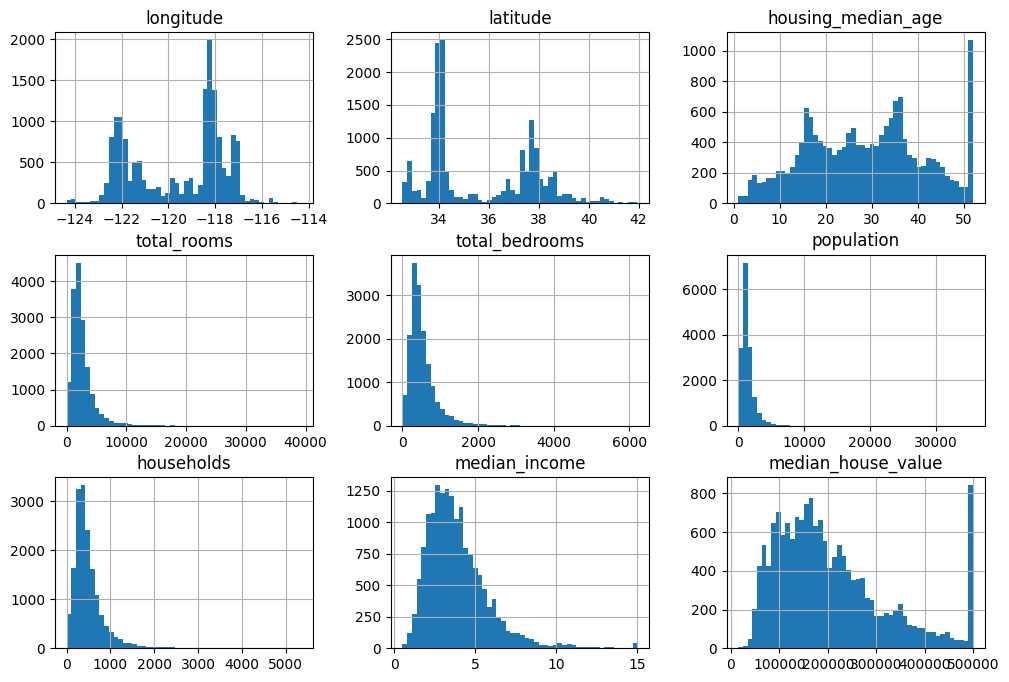

In [4]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12, 8))
plt.show()


**Interpretasi histogram (ringkas):**
- Banyak fitur (mis. `total_rooms`, `total_bedrooms`, `population`, `households`) condong ke kanan (*right-skewed*) → ada outlier dan skala yang jauh berbeda.
- `median_income` juga skewed; scaling akan membantu model sensitif skala.
- `housing_median_age` dan `median_house_value` terlihat punya nilai “mentok” (capped) di batas tertentu → ini perlu diingat saat evaluasi.
- Karena skala fitur berbeda jauh, preprocessing (imputasi + scaling + encoding kategori) penting sebelum training.


### 4.4 Visualisasi Sebaran Lokasi (Scatter Plot)

Kita mem-plot `longitude` vs `latitude` untuk melihat pola geografis sebaran data.  
`alpha` dibuat kecil supaya area yang padat titiknya terlihat lebih jelas.


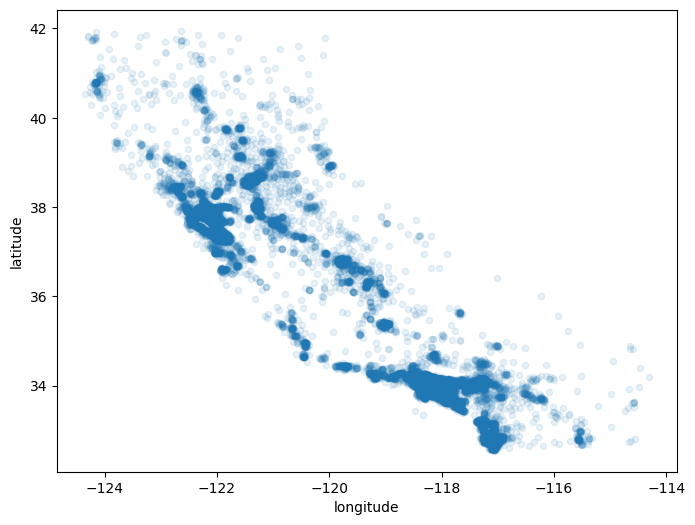

In [5]:
# Visualisasi geografis: sebaran rumah di California
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(8, 6))
plt.show()


### 4.5 Peta Harga Rumah (Warna) & Populasi (Ukuran Titik)

Visualisasi ini membantu melihat hubungan lokasi dengan harga rumah:
- Warna mewakili `median_house_value`
- Ukuran titik ~ `population`
Tujuannya: menangkap pola spasial (mis. area pesisir cenderung lebih mahal).


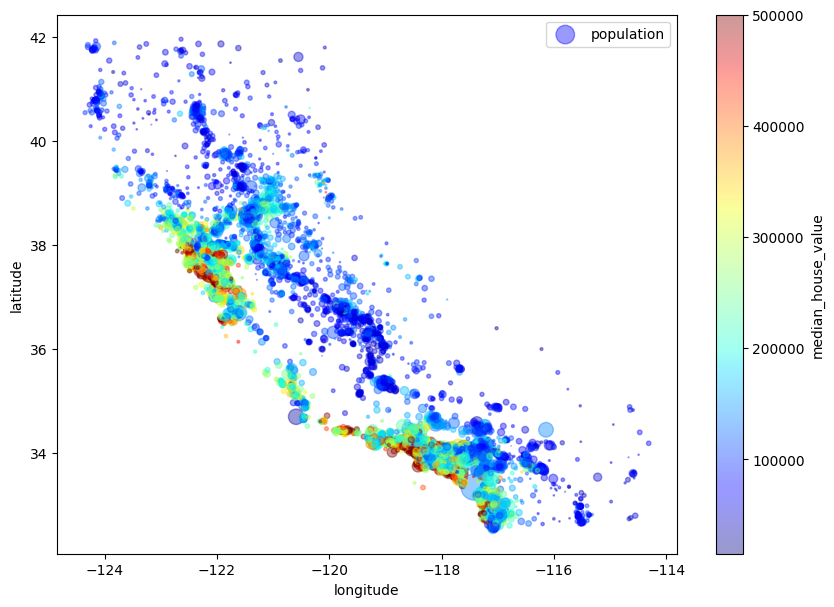

In [6]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=housing["population"] / 100,
    label="population",
    figsize=(10, 7),
    c="median_house_value",
    cmap="jet",
    colorbar=True,
)
plt.legend()
plt.show()


### 4.6 Korelasi Fitur terhadap Target

Di langkah ini kita menghitung matriks korelasi untuk fitur numerik, lalu melihat fitur mana yang paling berkorelasi dengan target `median_house_value`.  
Tujuan: membantu memilih fitur penting dan ide awal untuk feature engineering (mis. membuat rasio).


In [7]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)


,median_house_value
median_house_value,1.000000
median_income,0.687151
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population,-0.026882
longitude,-0.047466
latitude,-0.142673


**Insight korelasi (ringkas):**
- Fitur dengan korelasi paling kuat terhadap `median_house_value` adalah `median_income` (≈ 0.69).
- Korelasi fitur lain relatif kecil (mis. `total_rooms`, `housing_median_age`), sehingga kemungkinan butuh:
  - feature engineering (rasio seperti rooms/household)
  - model non-linear untuk menangkap pola yang tidak linier
- Korelasi bukan kausalitas, tapi membantu memprioritaskan fitur dan eksperimen.


### 4.7 Feature Engineering (Rasio) + Cek Korelasi Ulang

Kita membuat fitur rasio agar informasi yang dipakai model lebih “meaningful” dibanding nilai mentah, misalnya:
- jumlah kamar per rumah tangga
- proporsi kamar tidur terhadap total kamar
- populasi per rumah tangga

Setelah fitur dibuat, kita hitung ulang korelasi untuk melihat apakah fitur baru lebih informatif terhadap target.


In [8]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)


,median_house_value
median_house_value,1.000000
median_income,0.687151
rooms_per_household,0.146255
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population_per_household,-0.021991
population,-0.026882
longitude,-0.047466


### Feature Engineering (Rasio)
Di langkah ini kita membuat fitur rasio sederhana agar model menangkap informasi yang lebih relevan daripada nilai mentah (mis. jumlah kamar per rumah tangga).
Kita cek lagi korelasi fitur baru terhadap target `median_house_value`.


**Insight feature engineering:**
- `rooms_per_household` memberi korelasi sedikit lebih tinggi daripada `total_rooms` → rasio bisa lebih informatif daripada nilai mentah.
- `bedrooms_per_room` punya korelasi negatif yang cukup kuat → proporsi kamar tidur yang tinggi bisa mengindikasikan rumah lebih kecil/kurang bernilai.
- Rasio-rasio ini layak dimasukkan ke pipeline preprocessing sebagai fitur tambahan.


## 5) Data Preparation (Preprocessing Pipeline)


### 5.1 Pisahkan Fitur (X) dan Target (y)

Kita pisahkan:
- `housing` = fitur (semua kolom kecuali target)
- `housing_labels` = target `median_house_value`

Ini memudahkan preprocessing dan training model tanpa terjadi kebingungan antara input dan output.


In [10]:
# Pisahkan fitur (X) dan target (y)
housing = strat_train_set.drop("median_house_value", axis=1).copy()
housing_labels = strat_train_set["median_house_value"].copy()

housing.shape, housing_labels.shape


((16512, 9), (16512,))

### 5.2 Tangani Missing Values (Imputasi)

Dari EDA sebelumnya, kolom `total_bedrooms` memiliki missing values.  
Di tahap ini kita akan memakai **imputer** untuk mengisi nilai kosong (strategi umum: median) agar model bisa dilatih tanpa error.


In [11]:
from sklearn.impute import SimpleImputer

housing_num = housing.drop("ocean_proximity", axis=1)

imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)

X = imputer.transform(housing_num)
X.shape


(16512, 8)

### 5.3 Encoding Fitur Kategorikal (`ocean_proximity`)

Kolom `ocean_proximity` bertipe kategorikal (teks).  
Model ML umumnya membutuhkan input numerik, jadi kita perlu mengubah kategori menjadi representasi numerik.  
Pendekatan yang umum adalah **One-Hot Encoding**, yang membuat kolom biner untuk setiap kategori.


In [12]:
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[["ocean_proximity"]]

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

cat_encoder.categories_, housing_cat_1hot.shape


([array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)],
 (16512, 5))

### 5.4 Gabungkan Preprocessing dengan Pipeline

Agar langkah preprocessing rapi dan reproducible, kita akan membuat:
- Pipeline numerik: imputasi (median) + scaling
- Pipeline kategorikal: one-hot encoding

Lalu keduanya digabung memakai `ColumnTransformer` supaya preprocessing otomatis diterapkan pada kolom yang sesuai.


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape


(16512, 13)

## 6) Training & Evaluasi Model (Baseline)

Kita mulai dari model baseline sederhana (Linear Regression) untuk mendapatkan patokan performa.  
Evaluasi awal dilakukan pada training set menggunakan metrik regresi seperti **RMSE**.


### 6.1 Baseline — Linear Regression

Tujuan: membuat baseline regresi sederhana sebagai patokan performa awal sebelum mencoba model yang lebih kompleks.


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_rmse


np.float64(69050.56219504567)

**Interpretasi baseline (Linear Regression):**
- RMSE training ≈ **69,051**.
- Ini baru evaluasi di training set, jadi belum menggambarkan kemampuan generalisasi.
- Langkah berikutnya sebaiknya memakai **cross-validation** untuk mengukur performa yang lebih realistis dan mengecek risiko overfitting/underfitting.


In [15]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10
)

lin_rmse_scores = np.sqrt(-lin_scores)
lin_rmse_scores.mean(), lin_rmse_scores.std()


(np.float64(69204.32275494763), np.float64(2372.070791055922))

**Interpretasi cross-validation (Linear Regression):**
- Rata-rata RMSE CV (10-fold) ≈ **69,204** dengan std ≈ **2,372**.
- Nilai CV mirip dengan RMSE training, jadi model linear ini cenderung **underfitting** (tidak cukup fleksibel menangkap pola).
- Selanjutnya perlu coba model yang lebih kuat, misalnya **Decision Tree** atau **Random Forest**.


### 6.2 Model — Decision Tree Regressor

Tujuan: mencoba model non-linear yang mampu menangkap interaksi fitur, lalu mengecek generalisasi dengan cross-validation.


In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

tree_scores = cross_val_score(
    tree_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10
)

tree_rmse_scores = np.sqrt(-tree_scores)
tree_rmse_scores.mean(), tree_rmse_scores.std()


(np.float64(69081.361562518), np.float64(2296.288087393378))

**Interpretasi cross-validation (Decision Tree):**
- Rata-rata RMSE CV (10-fold) ≈ **69,081** dengan std ≈ **2,296**.
- Hasilnya masih **mirip** dengan Linear Regression pada CV → performa generalisasi belum banyak membaik.
- Decision Tree sering punya RMSE training sangat kecil (overfitting), jadi CV lebih penting untuk menilai generalisasi.
- Langkah berikutnya: coba model ensemble seperti **RandomForestRegressor** untuk performa yang biasanya lebih baik.


### 6.3 Model — Random Forest Regressor

Tujuan: memakai ensemble banyak decision tree untuk meningkatkan generalisasi dan menurunkan error dibanding single tree.


In [17]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(
    forest_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10
)

forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores.mean(), forest_rmse_scores.std()


(np.float64(49432.12678796127), np.float64(2124.8587921578355))

**Interpretasi cross-validation (Random Forest):**
- Rata-rata RMSE CV (10-fold) ≈ **49,432** dengan std ≈ **2,125**.
- Ini jauh lebih baik dibanding Linear Regression/Decision Tree (~69k), artinya model ensemble menangkap pola non-linear lebih baik.
- Dengan performa ini, Random Forest layak jadi kandidat utama untuk **tuning hyperparameter**.


## 7) Fine-Tuning Model (Hyperparameter Search)


### 7.1 Setup Grid Search (Random Forest)
Tujuan: menentukan ruang hyperparameter (`param_grid`) dan menyiapkan `GridSearchCV` untuk mencari kombinasi terbaik dengan cross-validation.


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {"n_estimators": [50, 100, 200], "max_features": [4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [50, 100], "max_features": [4, 6, 8]},
]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=-1
)


### 7.2 Jalankan Grid Search & Ambil Best Model
Tujuan: menjalankan proses pencarian, lalu mengambil hyperparameter terbaik dan estimasi RMSE terbaik dari cross-validation.


In [21]:

grid_search.fit(housing_prepared, housing_labels)

best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

best_params, best_rmse


({'bootstrap': False, 'max_features': 6, 'n_estimators': 100},
 np.float64(48992.94175082946))

**Hasil Grid Search:**
- Best params: `bootstrap=False`, `max_features=6`, `n_estimators=100`
- Estimasi RMSE terbaik (CV) ≈ **48,993**


### 7.3 Review Hasil (Top Configurations)
Tujuan: meninjau beberapa konfigurasi terbaik untuk memahami trade-off performa dan memastikan hasilnya stabil (tidak hanya 1 kombinasi yang bagus).


In [19]:
cvres = grid_search.cv_results_
for mean_score, params in sorted(zip(cvres["mean_test_score"], cvres["params"]), reverse=True)[:10]:
    rmse = np.sqrt(-mean_score)
    print(rmse, params)


48992.94175082946 {'bootstrap': False, 'max_features': 6, 'n_estimators': 100}
49009.1042786889 {'bootstrap': False, 'max_features': 4, 'n_estimators': 100}
49023.61886627402 {'max_features': 8, 'n_estimators': 200}
49100.656724131455 {'bootstrap': False, 'max_features': 6, 'n_estimators': 50}
49160.66522746081 {'max_features': 8, 'n_estimators': 100}
49170.09262795686 {'max_features': 6, 'n_estimators': 200}
49265.889308195525 {'bootstrap': False, 'max_features': 4, 'n_estimators': 50}
49366.1574509085 {'max_features': 6, 'n_estimators': 100}
49417.08400461182 {'max_features': 4, 'n_estimators': 200}
49485.628343968834 {'max_features': 8, 'n_estimators': 50}


**Insight hasil tuning:**
- Beberapa konfigurasi terbaik menghasilkan RMSE yang sangat berdekatan (~49.0k–49.5k), jadi performa relatif stabil di sekitar area ini.
- Setting `bootstrap=False` muncul pada posisi teratas → untuk dataset ini, opsi tersebut memberi sedikit keuntungan.
- Menambah `n_estimators` (mis. 200) tidak selalu lebih baik secara signifikan, tapi biasanya meningkatkan stabilitas dengan biaya komputasi.


## 8) Final Evaluation on Test Set


### 8.1 Siapkan Data Test


In [22]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared.shape, y_test.shape


((4128, 13), (4128,))

### 8.2 Prediksi & Hitung RMSE (Test Set)


In [23]:
from sklearn.metrics import mean_squared_error
import numpy as np

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse


np.float64(46519.79593324298)

**Hasil evaluasi final (Test Set):**
- RMSE test set ≈ **46,520**
- Ini adalah estimasi performa generalisasi yang lebih kredibel dibanding training score.
- Model terbaik (Random Forest hasil grid search) memberikan error yang jauh lebih rendah dibanding baseline linear (~69k).


## 9) Takeaways
- Proyek ML end-to-end perlu alur yang disiplin: split yang benar → EDA → preprocessing → training → evaluasi → tuning → test final.
- Stratified split membantu menjaga distribusi fitur penting agar train/test representatif.
- Pipeline + ColumnTransformer membuat preprocessing rapi dan mencegah data leakage.
- Model ensemble (Random Forest) jauh mengungguli model linear pada dataset ini.
- Evaluasi final wajib di test set untuk mengukur generalisasi.

## 10) Referensi
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, O’Reilly.
- Scikit-learn Documentation (Pipeline, ColumnTransformer, GridSearchCV).
